In [1]:
# Data
import numpy as np
import pandas as pd
import geopandas as gpd

# Dates
import datetime
import time
import julian

# Database
import sqlite3
import spatialite
import shapely

# Plotting
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler


### Getting the Data

Using data from the US Department of Agriculture, specifically referencing the Spatial wildfire occurrence data for the United States, 1992-2015 (y__FOD_20170508) (4th Edition).

In [2]:
%%time
conn_spa = spatialite.connect('../FPA_FOD_20170508.sqlite')
sql = '''
SELECT *, ST_AsBinary(Shape) as geom
FROM Fires 
'''
fpa = gpd.read_postgis(sql, conn_spa)
fpa.head()
conn_spa.close()

CPU times: user 1min 23s, sys: 20.4 s, total: 1min 44s
Wall time: 2min 17s


### Cleaning

In [3]:
fpa.shape

(1880465, 40)

In [4]:
fpa.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape', 'geom'],
      dtype='object')

In [5]:
# Function to clean column types and convert datatypes

def clean_columns(df):
    # Convert Owner_code to integer
    df['OWNER_CODE'] = df['OWNER_CODE'].astype(int)

    # Convert Discovery Date to datetime format from julian format
    df['DISCOVERY_DATE'] = df['DISCOVERY_DATE'].map(lambda x: julian.from_jd(x))
    
    # Create DISCOVERY Day of Week
    df['DISCOVERY_DAY_OF_WEEK'] = df['DISCOVERY_DATE'].map(lambda x: x.weekday())
    
    # Add a column for Discovery Month and 
    df['FIRE_MONTH'] = df['DISCOVERY_DATE'].map(lambda x: x.month)

    # Convert Containment date to datetime format from julian format
    df['CONT_DATE'] = df['CONT_DATE'].map(lambda x: julian.from_jd(x) if np.isnan(x) == False else x)

    # Convert label column to integers
    df['STAT_CAUSE_CODE'] = df['STAT_CAUSE_CODE'].astype(int)
    
    df['LOG10_FIRE_SIZE'] = np.round(np.log10(df['FIRE_SIZE']),2)
    return df

fpa = clean_columns(fpa)

In [6]:
fpa.shape

(1880465, 42)

Drop labels that are misc and undefined

In [10]:
# Function to drop unlabeled rows (Specifically code = 9 (other), 13(undefined))
def drop_unlabeled_rows(df):
    misc_mask = ~((df['STAT_CAUSE_CODE'] == 13) | (df['STAT_CAUSE_CODE'] == 9))
    print(f'Original dataframe shape = {df.shape}')
    print(f'Dropping {(~misc_mask).sum()} rows')
    return df[misc_mask]
fpa = drop_unlabeled_rows(fpa)

Original dataframe shape = (1880465, 42)
Dropping 490528 rows


We would expect to drop 490,528 rows that have miscellaneous causes or missing/undefined

In [11]:
fpa.shape

(1389937, 42)

In [12]:
fpa.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape', 'geom', 'DISCOVERY_DAY_OF_WEEK',
       'FIRE_MONTH'],
      dtype='object')

### Creating X and y

In [13]:
cause_dict = {
    1:{'category_id':0, 'label':'Lightning', 'category':'Natural'},
    2:{'category_id':1, 'label':'Equipment Use', 'category':'Human'},
    3:{'category_id':1, 'label':'Smoking', 'category':'Human'},
    4:{'category_id':1, 'label':'Campfire', 'category':'Human'},
    5:{'category_id':1, 'label':'Debris Burning', 'category':'Human'},
    6:{'category_id':1, 'label':'Railroad', 'category':'Human'},
    7:{'category_id':1, 'label':'Arson', 'category':'Human'},
    8:{'category_id':1, 'label':'Children', 'category':'Human'},
    9:{'category_id':2, 'label':'Miscellaneous', 'category':'Other'},
    10:{'category_id':1, 'label':'Fireworks', 'category':'Human'},
    11:{'category_id':1, 'label':'Powerline', 'category':'Human'},
    12:{'category_id':1, 'label':'Structure', 'category':'Human'},
    13:{'category_id':2, 'label':'Missing/Undefined', 'category':'Other'}
}

In [14]:
# Function to generate X and y datasets for training
def create_X_y(df):
    label = 'STAT_CAUSE_CODE'
    features = ['FIRE_YEAR','FIRE_MONTH','DISCOVERY_DOY','DISCOVERY_DAY_OF_WEEK','LATITUDE','LONGITUDE','OWNER_CODE', 'STATE', 'NWCG_REPORTING_AGENCY']
    X = df[features]
    y = df[label]
    return (X, y)
X, y = create_X_y(fpa)

In [15]:
# Function to dummy out our X dataset
def create_X_dummies(X):
    # Dummy out Owner Code
    X = X.merge(pd.get_dummies(X['OWNER_CODE'], drop_first = True, prefix = "owner_code"), 
                how = 'inner',
                left_index = True, 
                right_index = True)

    # Dummy out State
    X = X.merge(pd.get_dummies(X['STATE'], drop_first = True), 
                how = 'inner',
                left_index = True, 
                right_index = True)
    # Dummying out Reporting Agency
    X = X.merge(pd.get_dummies(X['NWCG_REPORTING_AGENCY'], drop_first = True, prefix = 'agency'), 
                how = 'inner',
                left_index = True, 
                right_index = True)
    # Drop our dummy columns
    X.drop(columns = ['OWNER_CODE','STATE', 'NWCG_REPORTING_AGENCY'], inplace= True)
    return X

X = create_X_dummies(X)

In [42]:
# Check the distribution of causes
cause_frequency = pd.Series(y.value_counts(normalize = True).values, 
          index = y.value_counts().index.map(lambda x: str(x) +'-'+ cause_dict[x]['label']), name = 'Frequency').sort_values(ascending = False)
cause_frequency

5-Debris Burning    0.308667
7-Arson             0.202495
1-Lightning         0.200346
2-Equipment Use     0.106200
4-Campfire          0.054779
8-Children          0.044007
3-Smoking           0.038037
6-Railroad          0.024069
11-Powerline        0.010395
10-Fireworks        0.008274
12-Structure        0.002731
Name: Frequency, dtype: float64

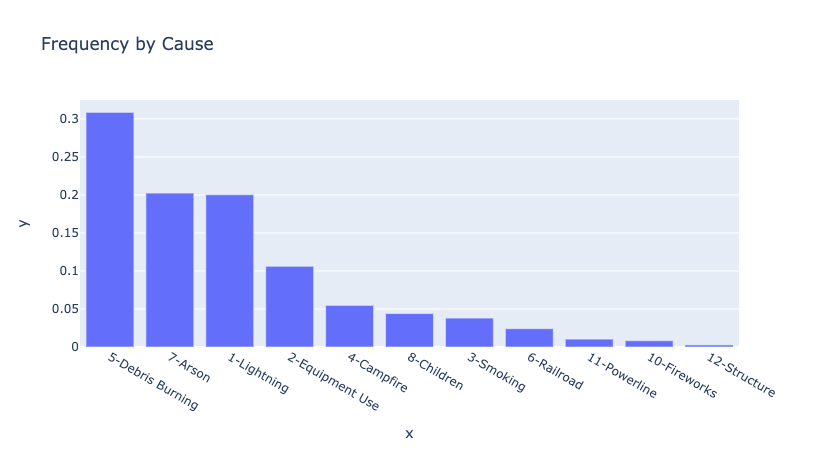

In [53]:
px.bar(x = cause_frequency.index, y = cause_frequency.values, title = 'Frequency by Cause', titie_x = 0.5)

### Decision Tree on all causes

In [54]:
# Train test split on multiple y columns
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [55]:
# Instantiate Model
def model_decision_tree(X_train, y_train):
    model = DecisionTreeClassifier(criterion = 'gini', 
                            max_depth = 200, 
                            min_samples_split = 100, 
                            min_samples_leaf = 10)

    # Fit Model
    model.fit(X_train, y_train)
    return model
dt = model_decision_tree(X_train, y_train)

# Print scores
print(f'Score on training set: {dt.score(X_train, y_train)}')
print(f'Score on testing set: {dt.score(X_test, y_test)}')

Score on training set: 0.6373358197787524
Score on testing set: 0.5927939335510886


In [56]:
# Getting predictions
preds = dt.predict(X_test)

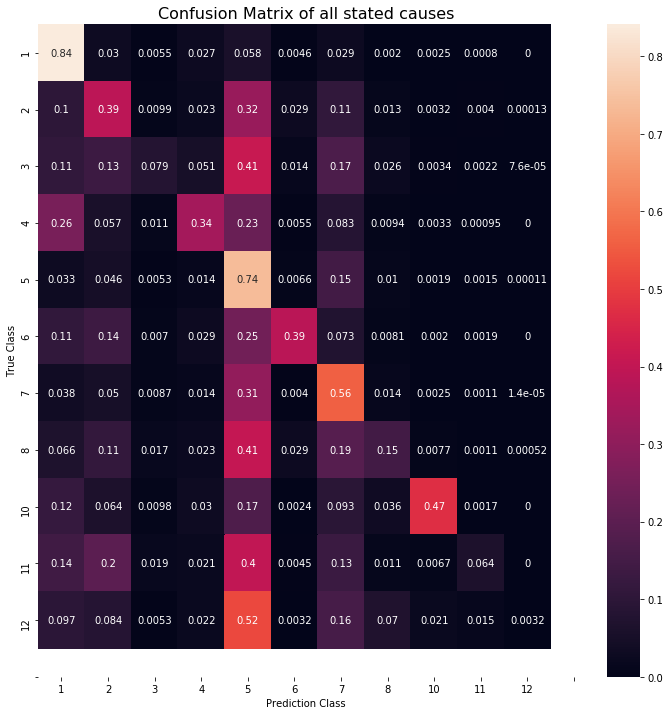

In [57]:
def plot_confusion_matrix(y_test, model):
    preds = model.predict(X_test)
    plt.figure(figsize = (12,12))
    plt.title('Confusion Matrix of all stated causes', fontdict = {'fontsize':16})

    sns.heatmap(confusion_matrix(y_test, 
                                 preds, 
                                 labels = [1,  2,  3, 4, 5, 6, 7, 8, 10, 11, 12], 
                                 normalize = 'true'), annot = True)
    plt.xlabel('Prediction Class')
    plt.ylabel('True Class')
    plt.xticks(ticks = [i - 0.5 for i in range(1,13)], labels = [1,  2,  3, 4, 5, 6, 7, 8, 10, 11, 12]);
    plt.yticks(ticks = [i - 0.5 for i in range(1,13)], labels = [1,  2,  3, 4, 5, 6, 7, 8, 10, 11, 12]);

plot_confusion_matrix(y_test, dt)



### Decision Tree on all Natural/Human causes

In [58]:
# Reassign y as only categorical
y = pd.Series([cause_dict[i]['category_id'] for i in y])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [60]:
# Baseline guessing; accuracy could be 79%
y.value_counts(normalize = True)

1    0.799654
0    0.200346
dtype: float64

In [61]:
def model_decision_tree_categorical(X_train, y_train):
    # Instantiate Model
    model = DecisionTreeClassifier(criterion = 'gini', 
                                max_depth = 200, 
                                min_samples_split = 100, 
                                min_samples_leaf = 10)
    # Fit Model
    model.fit(X_train, y_train)
    return model
dt_cat = model_decision_tree_categorical(X_train, y_train)
# Make Predictions
preds = dt_cat.predict(X_test)

print(f'Score on training set: {dt_cat.score(X_train, y_train)}')
print(f'Score on testing set: {dt_cat.score(X_test, y_test)}')

Score on training set: 0.9308524517195995
Score on testing set: 0.9220167777026347


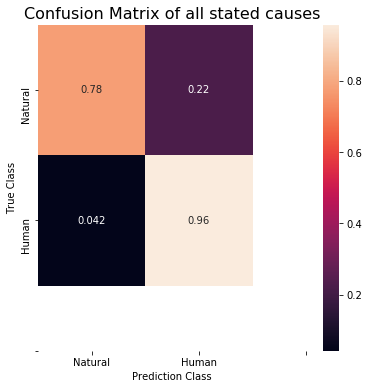

In [62]:

plt.figure(figsize = (6,6))
plt.title('Confusion Matrix of all stated causes', fontdict = {'fontsize':16})

sns.heatmap(confusion_matrix(y_test, 
                             preds, 
                             labels = [0,  1], 
                             normalize = 'true'), annot = True)
plt.xlabel('Prediction Class')
plt.ylabel('True Class')
plt.xticks(ticks = [i - 0.5 for i in range(1,4)], labels = ['Natural',  'Human']);
plt.yticks(ticks = [i - 0.5 for i in range(1,4)], labels = ['Natural',  'Human']);


### Grid Search over values

In [63]:
params = {
    'max_depth' : [100, 90, 110],
    'min_samples_split' : [100,150,180],
    'min_samples_leaf' : [30,40,50],
}

In [ ]:
%%time
def model_GridSearch_DecisionTree(X_train, y_train, params):
    model = GridSearchCV(DecisionTreeClassifier(random_state = 42), 
                        params,
                        cv = 5, 
                        verbose = 2)
    # Let's GridSearch over the above parameters on our training data.
    model.fit(X_train,y_train)
    return model

#grid = model_GridSearch_DecisionTree(X_train, y_train, params)
print(grid.best_estimator_)
print(grid.best_params_)
print()
print(f'Score on training set: {grid.score(X_train, y_train)}')
print(f'Score on testing set: {grid.score(X_test, y_test)}')

In [73]:
#
def collect_gridCV_results(model, name):
    # Create a dataframe of model parameters, and results
    model_history = pd.merge(pd.DataFrame(model.cv_results_['params']), # Get parameters
             pd.DataFrame(model.cv_results_['mean_test_score'], columns = ['mean_test_score']), # Get Scores
             how = 'inner',left_index = True, right_index = True)
    # Append name column
    model_history['model'] = name
    return model_history

gridCV_results = collect_gridCV_results(grid, 'DecisionTreeClassifier')

In [74]:
gridCV_results

,max_depth,min_samples_leaf,min_samples_split,mean_test_score,model
0,100,30,100,0.921074,DecisionTreeClassifier
1,100,30,150,0.920310,DecisionTreeClassifier
2,100,30,180,0.919970,DecisionTreeClassifier
3,100,40,100,0.920746,DecisionTreeClassifier
4,100,40,150,0.920028,DecisionTreeClassifier
5,100,40,180,0.919774,DecisionTreeClassifier
6,100,50,100,0.920350,DecisionTreeClassifier
7,100,50,150,0.919752,DecisionTreeClassifier
8,100,50,180,0.919678,DecisionTreeClassifier
9,90,30,100,0.921074,DecisionTreeClassifier


### Random Forest

In [ ]:
%%time
rf = RandomForestClassifier(n_estimators = 50, 
                            max_depth = 100, 
                            min_samples_split = 100, 
                            min_samples_leaf =40)

rf.fit(X_train, y_train)

print(f'Score on training set: {rf.score(X_train, y_train)}')
print(f'Score on testing set: {rf.score(X_test, y_test)}')

In [ ]:
rf.score(X_train, y_train)

In [ ]:
rf.score(X_test, y_test)

### AdaBoostClassifier

In [64]:
ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 2), n_estimators = 30)
ada.fit(X_train, y_train)
ada.score(X_train, y_train)


0.9010697854673405

In [66]:
preds = ada.predict(X_test)

In [67]:
log_loss(y_test, preds)

3.416500353941841

In [68]:
%%time
# Function to run an ada model
def model_ada(X_train, y_train):
    # Instantiate Model
    ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 100, 
                                                                     min_samples_split = 100, 
                                                                     min_samples_leaf = 30), 
                             n_estimators = 10)
    
    # Fit Model
    ada.fit(X_train, y_train)
    return ada

model_ada(X_train, y_train)
print(ada.score(X_train, y_train))
print(ada.score(X_test, y_test))


0.9010697854673405
0.9010835000071945


### KNN Classifier

In [63]:
%%time
def model_knn(X_train, y_train):
    # Instantiate Scaler
    ss = StandardScaler()
    
    # Fit and Transform X
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    # Instantiate Model
    KNC = KNeighborsClassifier(n_neighbors = 5)
    
    # Fit Model
    KNC.fit(X_train, y_train)

    return KNC

KNC = model_knn(X_train, y_train)

print(KNC.score(X_train, y_train))
print(KNC.score(X_test, y_test))

0.9480148726272288
0.9296401283508641
CPU times: user 5min 4s, sys: 6.8 s, total: 5min 10s
Wall time: 5min 34s


In [ ]:
preds = KNC.predict(X_test)

## Using a Neural Network for Classification

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split

In [ ]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [ ]:
y_train.shape

In [ ]:
X_train.iloc[0,:].shape[1]

In [ ]:
y_train.shape

In [ ]:
model = Sequential()
model.add(Dense(units = X_train.iloc[0,:].shape[0], 
                input_shape = (X_train.iloc[0,:].shape[0],), 
               activation = 'relu'))
#model.add(Dense(units = 20, activation = 'relu'))
#model.add(Dropout(0.8))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam', 
             metrics=['accuracy'])

In [ ]:
hist = model.fit(X_train_sc, y_train, 
         epochs = 8, 
         batch_size = 512, 
         validation_data = (X_test_sc, y_test)
         )

In [ ]:
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Test loss")
plt.legend();

### Multiclass NN

In [ ]:
np.sort(y.unique())

In [ ]:
y_NN = y.copy()
y_NN[y == 10] = 9
y_NN[y == 11] = 10
y_NN[y == 12] = 11

In [ ]:
#y_NN = to_categorical(y_NN)
X_train, X_test, y_train, y_test = train_test_split(X, y_NN)

In [ ]:
y_NN.shape

In [ ]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [ ]:
model = Sequential()
model.add(Dense(71, activation = 'relu', input_shape = (71,)))
# For multiclass we want 1 neuron per class
# Each neuron is focusing on each class
# First on Class 1, Class 2, Class 3
model.add(Dropout(0.5))
model.add(Dense(120,
               activation = 'relu'))

# Softmax activation function to pull out prob of which class wins
model.add(Dense(11,
               activation = 'softmax'))

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

In [ ]:
model.summary()

In [ ]:
hist = model.fit(X_train_sc, y_train, 
                 epochs = 5, 
                 batch_size = 512, 
                 validation_data = (X_test_sc, y_test))

In [ ]:
fires_by_year = fpa.groupby(by = '')